# 中国A股因子投资2019年汇报

学习班小组运用18年到19年的因子数据，用投资组合分析来验证2019年A股市场中10个因子高低组合间的收益差别。

股票样本来自于中国市场剔除金融、ST、停牌和上市不满一年股票后的全部A股。
首先，我们在每个季度开始前依据参考的因子值构造等权投资组合，再将投资组合持有至季度末，计算季度收益，再将季度收益累计成为年度收益。
我们计算了如下两组，一共十个因子：

因子的计算方式参照了美国因子网页的说明、学习班教材书目以及《Replicating Anomalies in China》中对中国市场因子的处理方式。
数据取自CSMAR中市场和会计的原始数据，每一季度只涉及市场数据的因子值从上季度末的时点得到。涉及会计数据的因子值时间点选取较为复杂，如下表：

当同时涉及会计数据与市场数据的值，我们确保会计数据和市场数据时间同步（取自同一个时间点）。

因子值是统一标准分开计算的，所以程序就不在汇报中展示了，具体的因子原始数据和处理程序打包放到了GitHub上专门分类文件夹中。这里我们直接读入处理完成的表格。因子数据处理成了index为股票代码，columns为季度序号，value为因子值的表格数据。

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib as mpl

rf用月度收益率累积为季度收益，这里monthly为全市场股票数据，所以用Acode筛选了属于A股的样本

In [2]:
monthly_data = pd.read_csv('monthly.csv')
Acode = pd.read_csv('Acode.csv')
monthly_data = pd.merge(monthly_data,Acode,on='code')
monthly_data = monthly_data[(monthly_data['exchcd']!=2)&(monthly_data['exchcd']!=8)]
monthly_data['date'] =  pd.to_datetime(monthly_data['date'])
monthly_data['year'] = monthly_data['date'].dt.year
monthly_data = monthly_data[monthly_data['year']==2019]
monthly_data['month'] = monthly_data['date'].dt.month
monthly_data['quarter'] = (monthly_data['month']-1) // 3
monthly_data['rt'] = monthly_data['rt'] + 1
quarter_rt = monthly_data.groupby(['code','quarter'])['rt'].prod().reset_index()
quarter_rt = pd.pivot(quarter_rt,index='code',columns='quarter',values = 'rt')
quarter_rt = quarter_rt -1

In [3]:
EBIT_TEV = pd.read_csv('factor1.csv',index_col = 0)
B_M = pd.read_csv('factor2.csv',index_col = 0)
E_P = pd.read_csv('factor3.csv',index_col = 0)
CF_P = pd.read_csv('factor4.csv',index_col = 0)
S_P = pd.read_csv('factor5.csv',index_col = 0)
Momentum = pd.read_csv('factor6.csv',index_col = 0)
Size = pd.read_csv('factor7.csv',index_col = 0)
Beta = pd.read_csv('factor8.csv',index_col = 0)
ROA = pd.read_csv('factor9.csv',index_col = 0)
FS_Score = pd.read_csv('factor10.csv',index_col = 0)
quarter_rt.columns = EBIT_TEV.columns#因为读进来的表格columns是str格式，而程序生成的表格columns是int格式

In [4]:
##处理出每个季度选股的标准，codemonth中的代码是每个月符合要求的A股股票代码
codemonth = pd.read_csv('stkcdmonth.csv')
codemonth['year'] = codemonth['month']//100
code_need0 = codemonth[(codemonth['year']==2018)&(codemonth['month']%100==12)]['stkcd'].tolist()
code_need1 = codemonth[(codemonth['year']==2019)&(codemonth['month']%100==3)]['stkcd'].tolist()
code_need2 = codemonth[(codemonth['year']==2019)&(codemonth['month']%100==6)]['stkcd'].tolist()
code_need3 = codemonth[(codemonth['year']==2019)&(codemonth['month']%100==9)]['stkcd'].tolist()
code_need=[code_need0,code_need1,code_need2,code_need3]

计算后面画图分析会用到的每季度满足要求的年综合收益。

In [5]:
def universal_CAGR(rt,code_list):
    X = []
    for i in rt.columns:
        rt_temp = rt[i]
        code = [x for x in rt_temp.index if x in code_list[int(i)]]
        rt_temp = rt_temp.loc[code]
        r = rt_temp.mean()
        X.append(r)
    CAGR = (pd.Series(X) + 1).prod()-1
    CAGR = CAGR*100
    return CAGR

u_CAGR = universal_CAGR(quarter_rt,code_need)

全部的输入数据都准备好了，进行构建投资组合并计算累积收益的程序：

In [7]:
##单边多头组合构建
def protofolio_split_single(factor,rt,percent,code_list,top=True):
    '''
用因子数据构建投资组合（只做多）计算四个季度累积收益

参数：
factor：index为股票代码，columns为期限，value为因子数值的数据，期限变为0123
rt：index为股票代码，columns为期限，value为季度内股票持有的收益率，期限变为0123，实际对应19年每个季度末的股票收益率
percent: 确定到底买入排名前或后百分之多少的股票
code_list:每期选股时点非金融和ST股票名单
top:=True 即为计算最高一部分投资组合的超额收益

输出：
累积超额收益(乘了一百，以百分号为单位)
    '''
    if top == 1:
        cut = 1 - percent
        t = 1
    else:
        cut = percent
        t = 0
    X = []
    for i in rt.columns:
        df = pd.concat([factor[i],rt[i]],axis=1,join = 'inner')
        code = [x for x in df.index if x in code_list[int(i)]]
        df = df.loc[code]
        df.columns = ['factor','rt']
        df = df.dropna()
        df['group'] = pd.qcut(df['factor'],[0,cut,1],labels=False)
        df = df[df['group'] == t]
        quater_rt = df['rt'].mean()
        X.append(quater_rt)
    X = (pd.Series(X) + 1).prod()-1
    X = 100*X
    return X

def protofolio_split(factor_list,name_list,rt,code_list):
    '''
    输入所以需要的因子列表和跟上面一样的rt格式，输出split画图需要的列表。
    name_list顺序要和factor_list一致，用来给表格中因子命名
    '''
    X = pd.DataFrame()
    for i in factor_list:
        x1 = protofolio_split_single(i,rt,0.1,code_list)
        x2 = protofolio_split_single(i,rt,0.1,code_list,False)
        x3 = protofolio_split_single(i,rt,1/3,code_list)
        x4 = protofolio_split_single(i,rt,1/3,code_list,False)
        x5 = protofolio_split_single(i,rt,0.5,code_list)
        x6 = protofolio_split_single(i,rt,0.5,code_list,False)
        x = pd.Series([x1,x2,x3,x4,x5,x6],index = ['Top10%','Bottom10%','Top1/3','Bottom1/3','Top50%','Bottom50%'])
        X = pd.concat([X,x],axis=1,sort=False)
    X.columns = name_list
    return X

value_factors = [EBIT_TEV,B_M,E_P,CF_P,S_P]
value_factors_name = ['EBIT/TEV','B/M','E/P','CF/P','S/P']
other_factors = [Momentum,Size,Beta,ROA,FS_Score]
other_factors_name = ['Momentum','Size','Beta','ROA','FS-Score']
value_factors_split = protofolio_split(value_factors,value_factors_name,quarter_rt,code_need)
other_factors_split = protofolio_split(other_factors,other_factors_name,quarter_rt,code_need)

##双边多空投资组合构建

def protofolio_ls_single(factor,rt,cut,code_list):
    '''
用因子数据构建投资组合（做多空）计算四个季度累积收益

参数：
factor：index为股票代码，columns为期限，value为因子数值的数据，期限变为0123
rt：index为股票代码，columns为期限，value为季度内股票持有的q收益率，期限变为0123，实际对应19年每个季度末的超额收益率
cut: 确定平分几份
code_list:每期选股时点非金融和ST股票名单

输出：
累积超额收益(乘了一百，以百分号为单位)
    '''
    X_top = []
    X_bottom = []
    for i in rt.columns:
        df = pd.concat([factor[i],rt[i]],axis=1,join = 'inner')
        code = [x for x in df.index if x in code_list[int(i)]]
        df = df.loc[code]
        df.columns = ['factor','rt']
        df = df.dropna()
        tiles = []
        for t in range(cut-1):
            tiles.append((t+1)/cut)
        breakpoints = df['factor'].describe(percentiles=tiles)[4:-1]
        B1 = [-np.inf]
        for j in range(cut-1):
            B1.append(breakpoints[j])
        B1.append(np.inf)
        temp = pd.DataFrame()
        for k in range(cut):
            x = df[(df['factor']>=B1[k])&(df['factor']<=B1[k+1])]
            x['group'] = k
            temp = pd.concat([temp,x],sort=False)
        df_top = temp[temp['group'] == cut-1]
        df_bottom = temp[temp['group'] == 0]
        quater_top = df_top['rt'].mean()
        quater_bottom = df_bottom['rt'].mean()
        X_top.append(quater_top)
        X_bottom.append(quater_bottom)
    X_top = (pd.Series(X_top) + 1).prod()-1
    X_bottom = (pd.Series(X_bottom) + 1).prod()-1
    X = (X_top - X_bottom)*100
    return X

def protofolio_ls(factor_list,name_list,rt,code_list):
    '''
    输入所以需要的因子列表和跟上面一样的rt格式，输出ls画图需要的列表。
    name_list顺序要和factor_list一致，用来给表格中因子命名
    '''
    X = pd.DataFrame()
    for i in factor_list:
        x1 = protofolio_ls_single(i,rt,2,code_list)
        x2 = protofolio_ls_single(i,rt,3,code_list)
        x3 = protofolio_ls_single(i,rt,5,code_list)
        x4 = protofolio_ls_single(i,rt,10,code_list)
        x = pd.Series([x1,x2,x3,x4],index = ['Half L/S','Tercile L/S','Quintile L/S','Decile L/S'])
        X = pd.concat([X,x],axis=1,sort=False)
    X.columns = name_list
    return X

value_factors_ls = protofolio_ls(value_factors,value_factors_name,quarter_rt,code_need)
other_factors_ls = protofolio_ls(other_factors,other_factors_name,quarter_rt,code_need)

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


画图

In [8]:
##单边组合构造图像
def bar_graph_split(df,CAGR):
    '''
    输入的df的columns是因子名字，index是产生不同投资组合的比例
    '''
    mpl.rcParams["font.sans-serif"] = ["SimHei"]
    mpl.rcParams["axes.unicode_minus"] = False
    x = np.array([1,3,5,7,9,11])
    bar_width = 0.3
    tick_label = df.index
    y1 = df.iloc[:,0]
    y2 = df.iloc[:,1]
    y3 = df.iloc[:,2]
    y4 = df.iloc[:,3]
    y5 = df.iloc[:,4]
    plt.bar(x-2*bar_width, y1, bar_width, color='darkorange', label=df.columns[0], alpha=0.7)
    plt.bar(x-bar_width, y2, bar_width, color = 'yellow', label=df.columns[1], alpha=0.5)
    plt.bar(x, y3, bar_width, color='lime', label=df.columns[2], alpha=0.7)
    plt.bar(x+bar_width, y4, bar_width, color='deepskyblue', label=df.columns[3], alpha=0.6)
    plt.bar(x+2*bar_width, y5, bar_width,color='mediumpurple', label=df.columns[4], alpha=0.7)
    plt.axhline(CAGR,0,12,color='deeppink',linewidth='0.8')
    plt.xlabel('投资组合构造')
    plt.ylabel('投资组合年度累计收益')
    plt.xticks(x, tick_label)
    plt.title('2019年A股市场因子单边多头组合年度累计收益')
    ax = plt.gca()
    ax.spines['right'].set_color('none') 
    ax.spines['top'].set_color('none')
    #ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    plt.legend(loc='best',frameon=False, bbox_to_anchor=(1,-0.12),ncol=5)
    plt.show()

#双边组合图像
def bar_graph_ls(df):
    '''
    输入的df的columns是因子名字，index是产生不同投资组合的比例
    '''
    mpl.rcParams["font.sans-serif"] = ["SimHei"]
    mpl.rcParams["axes.unicode_minus"] = False
    x = np.array([1,3,5,7,9])
    bar_width = 0.35
    tick_label = df.columns
    y1 = df.iloc[0,:]
    y2 = df.iloc[1,:]
    y3 = df.iloc[2,:]
    y4 = df.iloc[3,:]
    plt.barh(x-1.5*bar_width, y1, bar_width, color='r', label='Half', alpha=0.5)
    plt.barh(x-0.5*bar_width, y2, bar_width, color='yellow', label='Tercile', alpha=0.5)
    plt.barh(x+0.5*bar_width, y3, bar_width, color='deepskyblue', label='Quintile', alpha=0.5)
    plt.barh(x+1.5*bar_width, y4, bar_width, color='lightpink', label='Decile', alpha=1)
    #plt.barh(y, left=0, height=0.5, width=x)
    plt.xlabel('投资组合累计收益')
    plt.yticks(x,tick_label)
    plt.tick_params(labelsize=8)
    ax = plt.gca()
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data', 0))
    ax.spines['right'].set_color('none') 
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    plt.title('2019年A股市场因子多空头组合年度累计收益')
    plt.legend(loc='best',frameon=False, bbox_to_anchor=(1,-0.12),ncol=4)
    plt.show()

首先是五个价值因子的多空头投资组合累计收益的图，图中展示了分别取全部样本1/2,1/3,1/5和1/10构建的高减低投资组合年度累计收益

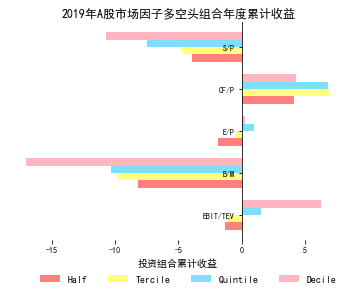

In [9]:
bar_graph_ls(value_factors_ls)

In [10]:
value_factors_ls.applymap(lambda x: round(x,2))

,EBIT/TEV,B/M,E/P,CF/P,S/P
Half L/S,-1.29,-8.23,-1.92,4.08,-3.91
Tercile L/S,-1.06,-9.83,-0.56,6.98,-4.76
Quintile L/S,1.55,-10.35,0.99,6.79,-7.49
Decile L/S,6.22,-17.04,0.25,4.25,-10.74


可以看到除了现金流于价格比值之外的其他因子都没有正向表现，反而是有一个负向的表现。高减低的收益率很明显为负。企业倍数的十分位值诡异地大于0，但是从账面市值比和销售价格比可以看到，当集中地买卖股票时（只投资于两头百分之10的股票），会得到更大的负值。

接下来看这五个价值因子的单边多头组合年度收益的情况,横线为全市场平均收益。

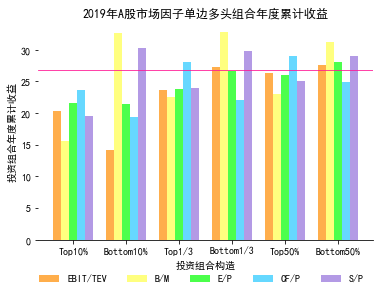

In [11]:
bar_graph_split(value_factors_split,u_CAGR)

In [12]:
value_factors_split.T.applymap(lambda x: round(x,2))

,Top10%,Bottom10%,Top1/3,Bottom1/3,Top50%,Bottom50%
EBIT/TEV,20.35,14.13,23.58,27.28,26.22,27.50
B/M,15.56,32.60,22.54,32.71,22.92,31.12
E/P,21.62,21.36,23.73,26.64,26.06,27.98
CF/P,23.56,19.31,28.03,22.06,29.02,24.92
S/P,19.53,30.27,23.93,29.77,25.07,28.99


可以看到的是，不管是做多高因子值的股票还是做多低因子值的股票，收益率绝对值普遍较高，所有的投资组合都有一个较高的回报。能够超过市场平均收益的投资组合主要集中在跟账面市值比因子和销售价格比因子相关的投资组合中，企业倍数高与低的投资组合的收益率都未超过市场平均收益率。

接着来看其他因子投资组合的表现情况。

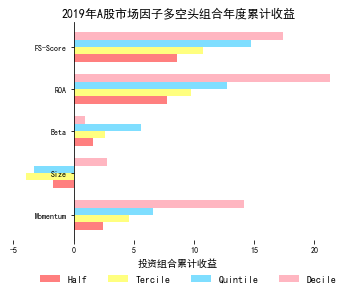

In [13]:
bar_graph_ls(other_factors_ls)

In [16]:
other_factors_ls.applymap(lambda x: round(x,2))

,Momentum,Size,Beta,ROA,FS-Score
Half L/S,2.42,-1.71,1.62,7.80,8.58
Tercile L/S,4.64,-3.96,2.62,9.73,10.72
Quintile L/S,6.62,-3.30,5.63,12.73,14.70
Decile L/S,14.14,2.78,0.95,21.32,0.00


除ROA和动量因子外，其他因子并没有展现理想的高减低正向收益（由于规模因子和beta因子的特殊性，两个高减低值为负才符合理想情况）。
而FS_Score因子的表现更有些许诡异，这个原因是由于分数只在0和10之前取整数，有过多重复值，
所以用单边分组的形式就会使边缘组样本较小，受噪音样本影响而导致极端数据。所以第二次修改后我们采取双边取值的投资组合，有了一个很完美的FS_Score因子结果。说明财务指标相关的因子2019年的表现较好。

规律和上图一致，能够更清晰的看到，ROA和动量因子多空头投资组合在市场上获得更高的收益率。且这种收益率被集中投资放大了（十等分高减低的收益率最高）。

接下来是单边多头的股票收益情况。

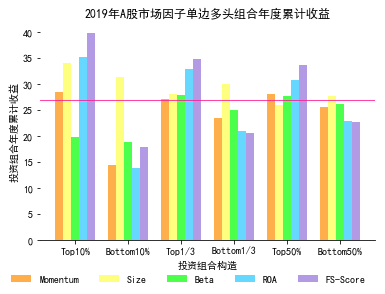

In [17]:
bar_graph_split(other_factors_split,u_CAGR)

In [18]:
value_factors_split.T.applymap(lambda x: round(x,2))

,Top10%,Bottom10%,Top1/3,Bottom1/3,Top50%,Bottom50%
EBIT/TEV,20.35,14.13,23.58,27.28,26.22,27.50
B/M,15.56,32.60,22.54,32.71,22.92,31.12
E/P,21.62,21.36,23.73,26.64,26.06,27.98
CF/P,23.56,19.31,28.03,22.06,29.02,24.92
S/P,19.53,30.27,23.93,29.77,25.07,28.99


同样的可以看到基本所有的投资组合都有较高的收益率绝对值。尽管市值的多空头组合收益率不尽人意，
但神奇的是而不管是极端大市值的公司，还是极端小市值的公司，都有超过市场平均收益率的收益率。而ROA的单边收益，
则完美地展现了ROA值与投资组合收益率的单调关系

## 总结

在所有验证的因子衡量中，只有价值因子中的现金流价格比因子以及其他因子中的ROA、动量因子和FS_Score因子表现都较好，尤其是ROA因子。有些因子甚至看起来与收益率并没有什么关系。用美股市场作者的原文来说，这是一个对价值投资者并不友好的一年。但是股市普遍的收益率很高，这对于投资者还算一个好消息。

报告中的估算较为简单，计算出来的投资组合收益率并不能完全代表19年进行因子投资的实际情况。首先报告并没有考虑交易成本于交易限制，且实际情况的调仓时间以及加权方式也不一定与报告中相同。且我们在市场投资中筛除了同样可以进行交易的ST和金融股，以及上市不满一年的股票，所以理论数值也可能与实际投资结果产生出入。